### 1. Introduction

### 2. Data Understanding

2.1 Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pymongo import MongoClient

- Read Dataset

In [ ]:
diabetes_dataset = pd.read_csv('diabetes.csv')
diabetes_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


-  Insert Dataset ke MongoDB

In [3]:
client = MongoClient("mongodb://localhost:27017/")
db = client["diabetes_db"]             
collection = db["data_diabetes"]

- convert t dictionary and insert to mongodb

In [6]:
data_dict = diabetes_dataset.to_dict("records")
collection.insert_many(data_dict)
print(f"Inserted {len(data_dict)} records into MongoDB.")

Inserted 768 records into MongoDB.


- Load Dataset dari MongoDB

In [7]:
# Ambil kembali data dari MongoDB
data = pd.DataFrame(list(collection.find()))

# Drop kolom _id jika ada
if '_id' in data.columns:
    data.drop('_id', axis=1, inplace=True)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 3. Data Understanding

In [8]:
# Shape
print("Jumlah baris dan kolom:", data.shape)

# Tipe data per kolom
print("\nTipe data:")
print(data.dtypes)

# Statistik deskriptif
print("\nStatistik deskriptif:")
print(data.describe(include='all'))

# Cek missing values
print("\nMissing values:")
print(data.isnull().sum())

# Cek duplikasi
print("\nJumlah duplikat:", data.duplicated().sum())


Jumlah baris dan kolom: (768, 9)

Tipe data:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Statistik deskriptif:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  

### 4. Data Cleaning

4.1 Tangani Missing Values

In [19]:
cols_with_zero_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Ubah nilai 0 menjadi NaN
data[cols_with_zero_missing] = data[cols_with_zero_missing].replace(0, np.nan)

# Isi NaN dengan median kolom masing-masing
for col in cols_with_zero_missing:
    data[col] = data[col].fillna(data[col].median())

# Periksa kembali missing values
print("Missing values setelah diisi:")
print(data.isnull().sum())

Missing values setelah diisi:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


4.2 Tangani Duplikasi

In [10]:
data.drop_duplicates(inplace=True)

4.3 Tangani Outlier

In [11]:
Q1 = data['BMI'].quantile(0.25)
Q3 = data['BMI'].quantile(0.75)
IQR = Q3 - Q1

# Deteksi outlier
outliers = data[(data['BMI'] < (Q1 - 1.5 * IQR)) | (data['BMI'] > (Q3 + 1.5 * IQR))]
print(f"Jumlah outlier BMI: {len(outliers)}")

# Hapus outlier (opsional)
data = data[~((data['BMI'] < (Q1 - 1.5 * IQR)) | (data['BMI'] > (Q3 + 1.5 * IQR)))]


Jumlah outlier BMI: 8


### 5. Data Transformation

5.1 Normalisasi Kolom Numerik

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Pisahkan kolom fitur dan target
X = data.drop("Outcome", axis=1)  # fitur
y = data["Outcome"]  # target

# Normalisasi fitur
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Konversi kembali ke DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)


5.3 Feature Engineering


In [13]:
# rasio antara Glucose dan BMI
X["Glucose_to_BMI"] = data["Glucose"] / (data["BMI"] + 1e-5)  # tambah epsilon utk hindari div/0

### 6. Simpan Data ke Excel

In [14]:
data.to_csv("diabetes_prepared.csv", index=False)

### 7.Exploratory Data Analysis / EDA

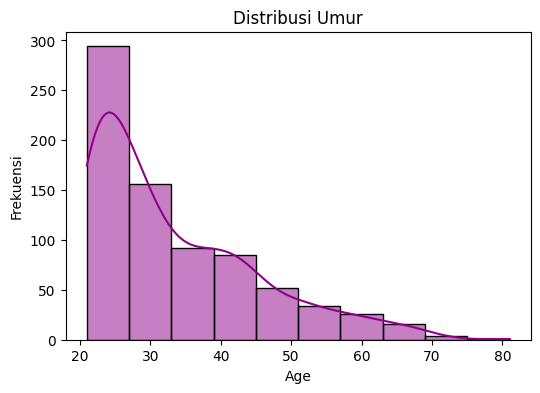

In [15]:
plt.figure(figsize=(6, 4))
sns.histplot(data=data, x='Age', bins=10, kde=True, color='#91008a')

plt.title('Distribusi Umur')
plt.xlabel('Age')
plt.ylabel('Frekuensi')
plt.show()

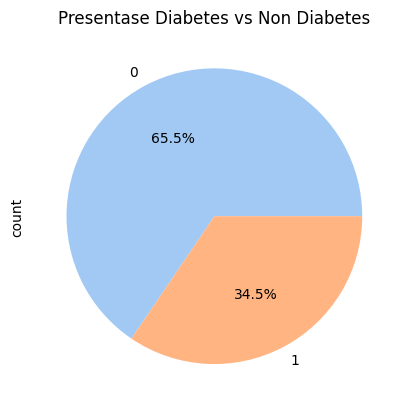

In [16]:
sns.set_palette('pastel')
data['Outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Presentase Diabetes vs Non Diabetes')
plt.show()

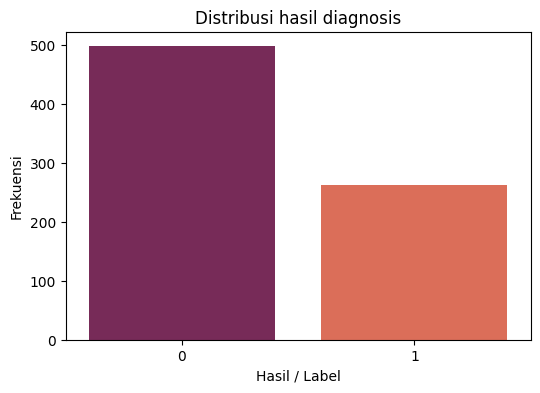

In [18]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Outcome', hue='Outcome', palette='rocket', legend=False)

plt.title('Distribusi hasil diagnosis')
plt.xlabel('Hasil / Label')
plt.ylabel('Frekuensi')
plt.show()

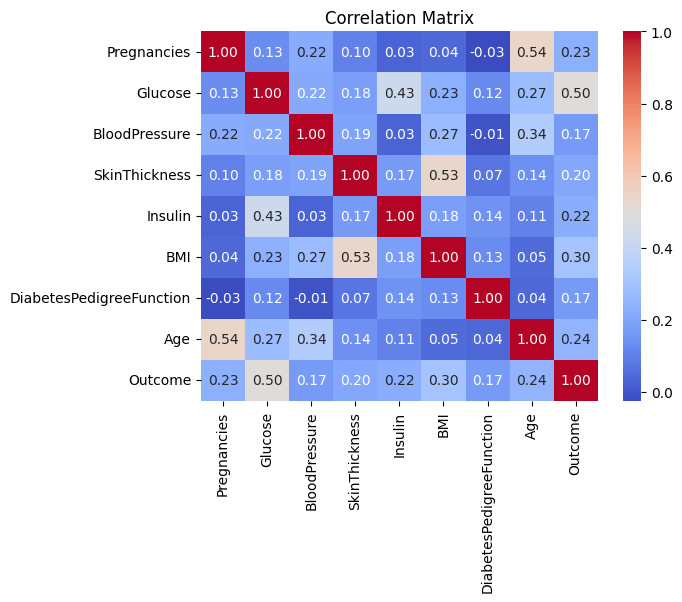

In [ ]:
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

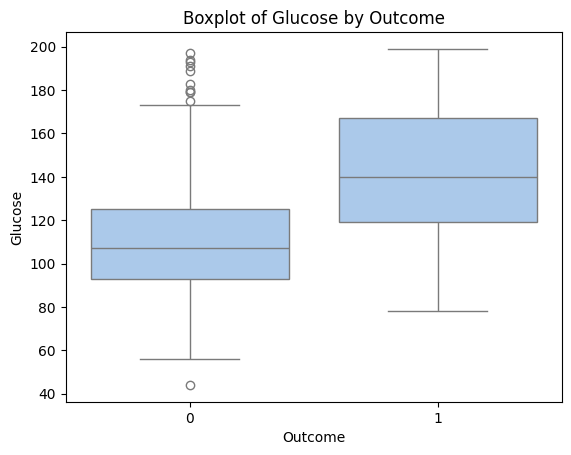

In [ ]:
sns.boxplot(x="Outcome", y="Glucose", data=data)
plt.title("Boxplot of Glucose by Outcome")
plt.show()

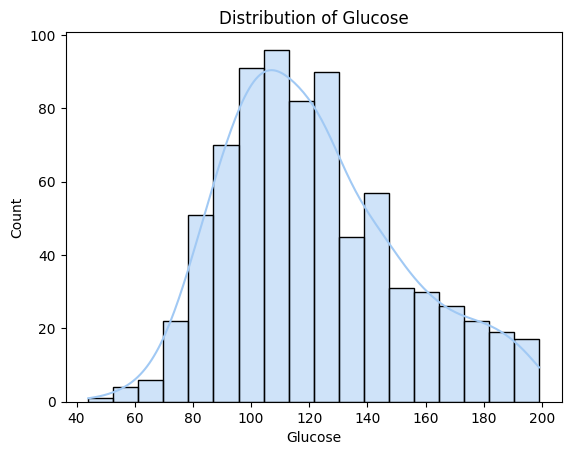

In [ ]:
sns.histplot(data["Glucose"], kde=True)
plt.title("Distribution of Glucose")
plt.show()